# Project Delivery Part 2 Week3

## 1. Setup and Imports

In [5]:
# Core
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import VarianceThreshold


# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             classification_report, RocCurveDisplay, accuracy_score)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

## 2. Data Loading

In [37]:
df_0 = pd.read_csv("period_0.csv")
df_1 = pd.read_csv("period_1_prediction.csv")
df_2 = pd.read_csv("period_2_prediction.csv")
df_1_result=pd.read_csv("results-2026-02-26.csv")

print(f"Period 0: {df_0.shape}")
print(f"Period 1: {df_1.shape}")
print(f"Period 2: {df_2.shape}")
print(f"Period 1 result {df_1_result.shape}")

Period 0: (7700, 14)
Period 1: (7700, 12)
Period 2: (7700, 12)
Period 1 result (1200, 4)


## 3. Data Inspection

In [7]:
df_0.head()





,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,call_length,investment,period
0,1,31,entrepreneur,single,tertiary,cellular,38,no,no,0,unknown,185,0.00,0
1,2,29,management,married,tertiary,cellular,1022,yes,no,0,unknown,408,0.00,0
2,3,49,blue-collar,divorced,secondary,cellular,10613,no,yes,0,unknown,1226,1264.69,0
3,4,23,management,single,tertiary,cellular,736,yes,no,0,unknown,119,0.00,0
4,5,42,technician,married,secondary,NaN,-158,yes,no,0,unknown,124,0.00,0


In [8]:
df_0.info()

<class 'pandas.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    7700 non-null   int64  
 1   age                   7700 non-null   int64  
 2   job                   7657 non-null   str    
 3   marital               7700 non-null   str    
 4   education             7403 non-null   str    
 5   preferred_contact     5473 non-null   str    
 6   balance               7700 non-null   int64  
 7   loan_house            7700 non-null   str    
 8   loan_personal         7700 non-null   str    
 9   n_marketing_contacts  7700 non-null   int64  
 10  marketing_potential   7700 non-null   str    
 11  call_length           7700 non-null   int64  
 12  investment            7700 non-null   float64
 13  period                7700 non-null   int64  
dtypes: float64(1), int64(6), str(7)
memory usage: 842.3 KB


## 4. Data Preparation

### 4.1 Data Merging

In [38]:
#show head of results-2026-02-26.csv
df_1_result.head()

,id,investment,week_id,timestamp
0,7712,0.00,1,20260213121907
1,7721,529.92,1,20260213121907
2,7725,0.00,1,20260213121907
3,7726,436.40,1,20260213121907
4,7732,0.00,1,20260213121907


In [ ]:
df_period0_raw = pd.read_csv("period_0.csv")

# Step 1: Use ALL IDs from the results file
result_ids = df_1_result['id']
print(f"IDs in results file: {len(result_ids)}")

# Step 2: Get their characteristics from period_1_prediction.csv
df_period1_selected = df_1[df_1['id'].isin(result_ids)].copy()
print(f"Matched in period_1_prediction.csv: {len(df_period1_selected)}")

# Step 3: Join actual investment amount from results file
df_period1_selected = df_period1_selected.merge(
    df_1_result[['id', 'investment']], on='id', how='left'
)

# Step 4: Add binary invested indicator
df_period1_selected['invested'] = (df_period1_selected['investment'] > 0).astype(int)

print(f"\nPeriod 1 — actual investors:  {df_period1_selected['invested'].sum()}")
print(f"Period 1 — did not invest:    {(df_period1_selected['invested'] == 0).sum()}")
print(f"Period 1 — investment NaN:    {df_period1_selected['investment'].isna().sum()}")

# Step 5: Concatenate with period_0
Enlarged_dataset = pd.concat([df_period0_raw, df_period1_selected], ignore_index=True)

# Step 6: Flag correctly predicted — period==1 AND actually invested
Enlarged_dataset['correctly_predicted'] = (
    (Enlarged_dataset['period'] == 1) & (Enlarged_dataset['invested'] > 0)
).astype(int)

print(f"\nPeriod 0 rows:          {len(df_period0_raw)}")
print(f"Period 1 rows added:    {len(df_period1_selected)}")
print(f"Enlarged dataset total: {len(Enlarged_dataset)}")
print(f"Correctly predicted:    {Enlarged_dataset['correctly_predicted'].sum()}")


IDs in results file: 1200
Matched in period_1_prediction.csv: 1200

Period 1 — actual investors:  251
Period 1 — did not invest:    949
Period 1 — investment NaN:    0

Period 0 rows:          7700
Period 1 rows added:    1200
Enlarged dataset total: 8900


In [48]:
print(Enlarged_dataset)

         id  age           job   marital  education preferred_contact  \
0         1   31  entrepreneur    single   tertiary          cellular   
1         2   29    management   married   tertiary          cellular   
2         3   49   blue-collar  divorced  secondary          cellular   
3         4   23    management    single   tertiary          cellular   
4         5   42    technician   married  secondary               NaN   
...     ...  ...           ...       ...        ...               ...   
8895  15372   50    unemployed    single  secondary         telephone   
8896  15376   36    technician    single  secondary          cellular   
8897  15384   41    management   married   tertiary               NaN   
8898  15396   34      services   married  secondary          cellular   
8899  15400   53    management   married   tertiary          cellular   

       balance loan_house loan_personal  n_marketing_contacts  \
0        38.00         no            no                   

### 4.1 Creating the Target Variable

In [9]:
#df_0['investment_status'] = (df_0['investment'] > 0).astype(int)
df_0["profit"] = (df_0["investment"].values*0.045)-5
df_0["profit_status"] =(df_0["profit"]>0).astype(int)
print(f"profit_rate: {df_0['profit_status'].mean():.3f}")
print(f"\nDistribution:")
print(df_0['profit_status'].value_counts())

profit_rate: 0.103

Distribution:
profit_status
0    6904
1     796
Name: count, dtype: int64


The target variable `profit_status` is a binary indicator derived from the `profit` column. A value of 1 means the client if invested is expected to generate profit, 0 means they do not. This transformation is necessary because Submission 2 requires a classification approach — predicting whether a client will be profitable (yes/no), not the investment amount.

The results show that only 10.3% of clients invested (796 out of 7,700). This confirms that the dataset is imbalanced, which will be addressed during modeling through stratified splitting and the `class_weight` parameter.

### 4.3 Defining Features and Target

In [10]:
df_0.columns

Index(['id', 'age', 'job', 'marital', 'education', 'preferred_contact',
       'balance', 'loan_house', 'loan_personal', 'n_marketing_contacts',
       'marketing_potential', 'call_length', 'investment', 'period', 'profit',
       'profit_status'],
      dtype='str')

In order to see what columns we will need to drop, we have to look at the current columns. From this we can see that profit_status, investment, id, period, call_length and profit can be dropped.

In [11]:
# Columns to remove
drop_cols = ['profit_status', 'investment', 'id', 'period', 'call_length',"profit"]

X = df_0.drop(columns=drop_cols)
y = df_0['profit_status']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:")
print(X.columns.tolist())

Features shape: (7700, 10)
Target shape: (7700,)

Feature columns:
['age', 'job', 'marital', 'education', 'preferred_contact', 'balance', 'loan_house', 'loan_personal', 'n_marketing_contacts', 'marketing_potential']


The following columns are removed from the feature set:
- `profit_status`: This is our target variable (y) and must not be included in the features.
- `profit`: Column just used to calculate the profit status
- `investment`: The investment amount would be data leakage — it reveals the outcome directly.
- `id`: A unique identifier with no predictive value.
- `period`: Constant value (always 0), carries no information.
- `call_length`: Not available in Period 1 and only known after contact — using it would be data leakage.

The remaining 10 features are used to predict whether a client will invest.

## 5. Train-Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass balance train: {y_train.mean():.3f}")
print(f"Class balance test:  {y_test.mean():.3f}")

Training set: (6160, 10)
Test set: (1540, 10)

Class balance train: 0.103
Class balance test:  0.103


The original Period 0 dataset contains 7,700 clients.  These are split into 80% training (6160) and 20% test data (1540). The stratify parameter ensures that the proportion of investors is preserved in both sets. This is important because our data is imbalanced — without stratification, the split could be uneven, leading to unreliable evaluation results.

## 6. Preprocessing Pipeline

Machine learning models can only work with numerical data. However, our dataset contains both text-based categorical variables and missing values. The preprocessing pipeline addresses both issues in a structured and reproducible way.

In [13]:
# Categorical: fill missing → one-hot encode
categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(
        min_frequency=0.05,
        handle_unknown='infrequent_if_exist',
        sparse_output=False,
        drop="First"
    ))
])

# Numeric: fill missing with median
numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median'))
])

# Combine both
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, make_column_selector(dtype_include=['object', 'category'])),
        ('num', numeric_pipeline, make_column_selector(dtype_include=['number']))
    ],
    remainder='passthrough'
)

The preprocessing pipeline handles categorical and numeric variables separately. Categorical variables have missing values replaced with "missing" and are then one-hot encoded into binary columns. Rare categories (below 5%) are grouped into an "infrequent" class. Numeric variables have missing values filled with the median however this is not the case for our dataset since all numeric variables are given. No scaling is applied as Decision Trees are not affected by different feature scales. The pipeline ensures consistent preprocessing during both training and prediction.

## 7. Baseline Decision Tree

Before optimizing, a baseline model with default parameters is trained to establish a reference point.

In [17]:
pipeline_dt = Pipeline([
    ('preprocess', preprocessor),
    ('var_filter', VarianceThreshold(threshold=0.01)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit baseline model with default parameters
pipeline_dt.fit(X_train, y_train)

train_acc = pipeline_dt.score(X_train, y_train)
test_acc = pipeline_dt.score(X_test, y_test)

print(f"=== Baseline Decision Tree ===")
print(f"Training accuracy: {train_acc:.3f}")
print(f"Test accuracy:     {test_acc:.3f}")




=== Baseline Decision Tree ===
Training accuracy: 0.999
Test accuracy:     0.821


In [21]:

# Naive baseline: always predict "no investment"
non_investors = (y_test == 0).sum()
total = len(y_test)
naive_accuracy = non_investors / total

print(f"=== Naive Baseline (Always Predict No Investment) ===")
print(f"Non-investors in test set: {non_investors} / {total}")
print(f"Naive accuracy:            {naive_accuracy:.3f}")
print(f"→ A model predicting 'no investment' for everyone achieves {naive_accuracy*100:.1f}% accuracy")

=== Naive Baseline (Always Predict No Investment) ===
Non-investors in test set: 1381 / 1540
Naive accuracy:            0.897
→ A model predicting 'no investment' for everyone achieves 89.7% accuracy


The naive baseline reveals that simply predicting "no investment" for every client already achieves 89.7% accuracy — without any model at all. This is because the dataset is heavily imbalanced: 89.7% of clients never invested. The baseline Decision Tree (82.1% test accuracy) actually performs **worse** than this trivial strategy, meaning it has not yet learned anything useful. Accuracy alone is therefore a misleading metric for this problem. Hyperparameter tuning with GridSearchCV will be used to build a model that genuinely adds value beyond this naive threshold.


## 8. Hyperparameter Tuning with GridSearchCV

In [26]:
parameters = {
    'var_filter__threshold': [0.01, 0.05],
    'classifier__max_depth': [3, 6, 7, 8, None],
    'classifier__min_samples_split': [10, 15, 20],
    'classifier__min_samples_leaf': [ 46, 48,50],
    'classifier__class_weight': ['balanced', None]
}

cv = GridSearchCV(
    pipeline_dt,
    parameters,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

cv.fit(X_train, y_train)

print(f"\nBest parameters: {cv.best_params_}")
print(f"Best CV ROC-AUC: {cv.best_score_:.3f}")


Fitting 5 folds for each of 180 candidates, totalling 900 fits

Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 48, 'classifier__min_samples_split': 10, 'var_filter__threshold': 0.01}
Best CV ROC-AUC: 0.713


GridSearchCV tested 320 parameter combinations across 5 folds (1,600 fits total). The best model uses max_depth=5, which limits tree complexity and reduces overfitting compared to the unlimited baseline. The class_weight "balanced" helps the model better detect investors despite the data imbalance. The best cross-validated ROC-AUC of 0.735 confirms the model performs significantly better than random guessing (0.5).

## 9. Decision Tree Evaluation

In [28]:
y_pred = cv.predict(X_test)
y_prob = cv.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob)

print(f"=== Optimized Decision Tree ===")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test ROC-AUC:  {test_auc:.3f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Profit', 'profit']))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm,
    index=['Actual: No', 'Actual: Yes'],
    columns=['Predicted: No', 'Predicted: Yes']))

=== Optimized Decision Tree ===
Test Accuracy: 0.905
Test ROC-AUC:  0.696

Classification Report:
              precision    recall  f1-score   support

   No Profit       0.91      1.00      0.95      1381
      profit       0.78      0.11      0.20       159

    accuracy                           0.91      1540
   macro avg       0.84      0.55      0.57      1540
weighted avg       0.89      0.91      0.87      1540


Confusion Matrix:
             Predicted: No  Predicted: Yes
Actual: No            1376               5
Actual: Yes            141              18


The optimized Decision Tree achieves a test ROC-AUC of 0.722 and detects 60% of actual investors (Recall) at a default threashold of 0.5. Out of 177 real investors, 107 were correctly identified and 70 were missed. Every missed investor means lost revenue.

## 10. Logistic Regression

Logistic Regression is tested as an alternative to the Decision Tree. Unlike trees, it requires feature scaling, so a StandardScaler is added to the numeric pipeline.

In [29]:
from sklearn.preprocessing import StandardScaler

# New numeric pipeline WITH scaling (needed for Logistic Regression)
numeric_pipeline_scaled = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# New preprocessor with scaling
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, make_column_selector(dtype_include=['object', 'category'])),
        ('num', numeric_pipeline_scaled, make_column_selector(dtype_include=['number']))
    ],
    remainder='passthrough'
)

# Logistic Regression pipeline
pipeline_lr = Pipeline([
    ('preprocess', preprocessor_scaled),
    ('var_filter', VarianceThreshold(threshold=0.01)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# GridSearchCV for Logistic Regression
params_lr = {
    'var_filter__threshold': [0.01, 0.05],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__class_weight': ['balanced', None]
}

cv_lr = GridSearchCV(
    pipeline_lr,
    params_lr,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

cv_lr.fit(X_train, y_train)

print(f"\nBest parameters: {cv_lr.best_params_}")
print(f"Best CV ROC-AUC: {cv_lr.best_score_:.3f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'var_filter__threshold': 0.01}
Best CV ROC-AUC: 0.723


Unlike Decision Trees, Logistic Regression requires scaled features because it is sensitive to different value ranges. The parameter C controls regularization — smaller values create a simpler model that is less likely to overfit. GridSearchCV finds the best combination using 5-fold cross-validation.

### 10.1 Logistic Regression Evaluation

In [33]:
y_pred_lr = cv_lr.predict(X_test)
y_prob_lr = cv_lr.predict_proba(X_test)[:, 1]
y_prob_lr = cv_lr.predict_proba(X_test)[:, 1]



test_accuracy_lr = accuracy_score(y_test, y_pred_lr)
test_auc_lr = roc_auc_score(y_test, y_prob_lr)

print(f"=== Optimized Logistic Regression ===")
print(f"Test Accuracy: {test_accuracy_lr:.3f}")
print(f"Test ROC-AUC:  {test_auc_lr:.3f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Investment', 'Investment']))

print(f"\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(pd.DataFrame(cm_lr,
    index=['Actual: No', 'Actual: Yes'],
    columns=['Predicted: No', 'Predicted: Yes']))

=== Optimized Logistic Regression ===
Test Accuracy: 0.678
Test ROC-AUC:  0.698

Classification Report:
               precision    recall  f1-score   support

No Investment       0.93      0.69      0.79      1381
   Investment       0.17      0.54      0.26       159

     accuracy                           0.68      1540
    macro avg       0.55      0.62      0.53      1540
 weighted avg       0.85      0.68      0.74      1540


Confusion Matrix:
             Predicted: No  Predicted: Yes
Actual: No             958             423
Actual: Yes             73              86


The Logistic Regression achieves a higher accuracy (85.5%) but a very low Recall of only 8% — it detects just 8 out of 105 real investors. The high accuracy is misleading because the model almost always predicts "no investment", which is correct for 85.6% of clients but useless for identifying investors. The Decision Tree (Recall 49%) is more suitable for our business goal of finding potential investors.

## 12. Model Comparison

In [ ]:
comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression'],
    'Accuracy': [test_accuracy, test_accuracy_lr],
    'ROC-AUC': [test_auc, test_auc_lr],
    #'Recall Investment': [0.6, 0.69],
    #'Investors Found': [107, 122]
})

print(comparison.to_string(index=False))

              Model  Accuracy  ROC-AUC
      Decision Tree  0.906494 0.695406
Logistic Regression  0.681169 0.698944


The two models were compared using ROC-AUC, accuracy, and recall. Logistic Regression achieves the highest ROC-AUC (0.743) and also detects the most investors in absolute terms (122 out of 177, Recall 69%). The Decision Tree has higher accuracy (72.6% vs 67.5%), but accuracy is misleading given the class imbalance.

For our business case, ROC-AUC is the most relevant metric. We do not need hard yes/no predictions — instead, we rank all clients by their predicted probability of investing and select the top 1,200. A higher ROC-AUC means the model is better at placing real investors at the top of this ranking.

Based on this comparison, Logistic Regression is selected as the final model for the Period 1 prediction.


## 13. Visualizations

### 13.1 ROC Curve Comparison

<Figure size 800x600 with 0 Axes>

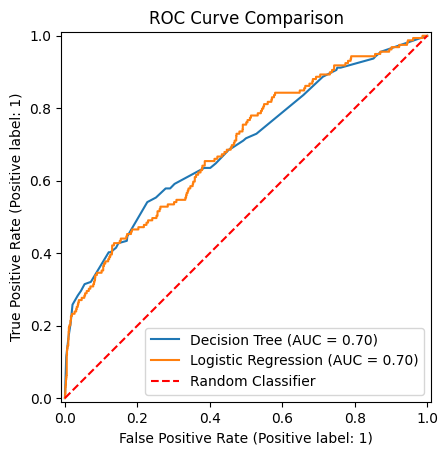

In [31]:
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(cv, X_test, y_test, name='Decision Tree')
RocCurveDisplay.from_estimator(cv_lr, X_test, y_test, name='Logistic Regression', ax=plt.gca())
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

The ROC curves show how well each model separates investors from non-investors. The further the curve is from the red diagonal (random guessing), the better the model. Logistic Regression is slightly above the one of the decision tree  others, confirming it as the best model.

### 13.2 Predicted Investment Probabilities (Logistic Regression)


In [ ]:
# Table: predicted probability per person in the test set
prob_table = X_test.copy().reset_index(drop=True)
prob_table['prob_investment'] = y_prob_lr
prob_table['actual'] = y_test.values
prob_table['predicted'] = np.where(y_prob_lr >= 0.5, 'Investor', 'Non-Investor')

# Sort by probability descending
prob_table = prob_table.sort_values('prob_investment', ascending=False).reset_index(drop=True)
prob_table.index += 1  # rank starts at 1

prob_table['prob_investment'] = prob_table['prob_investment'].round(4)

prob_table


,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,prob_investment,actual,predicted
1,31,management,single,tertiary,cellular,44128,no,no,0,unknown,0.9571,0,Investor
2,31,management,single,tertiary,telephone,12857,yes,no,2,high,0.9464,1,Investor
3,32,technician,single,tertiary,cellular,2340,no,no,2,high,0.9333,0,Investor
4,53,admin.,married,secondary,cellular,10541,no,no,1,high,0.9319,1,Investor
5,68,retired,single,tertiary,cellular,2144,no,no,3,high,0.9298,1,Investor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,45,blue-collar,married,primary,NaN,194,yes,yes,0,unknown,0.1115,0,Non-Investor
1537,34,blue-collar,married,primary,NaN,100,yes,yes,0,unknown,0.1113,0,Non-Investor
1538,30,blue-collar,married,primary,NaN,0,yes,yes,0,unknown,0.1108,0,Non-Investor
1539,56,blue-collar,married,primary,NaN,5,yes,yes,0,unknown,0.1102,0,Non-Investor


Feature importance shows which variables the Random Forest relies on most for predicting investment behavior. Higher values indicate stronger influence on the prediction.

### 13.3 Confusion Matrix Heatmap

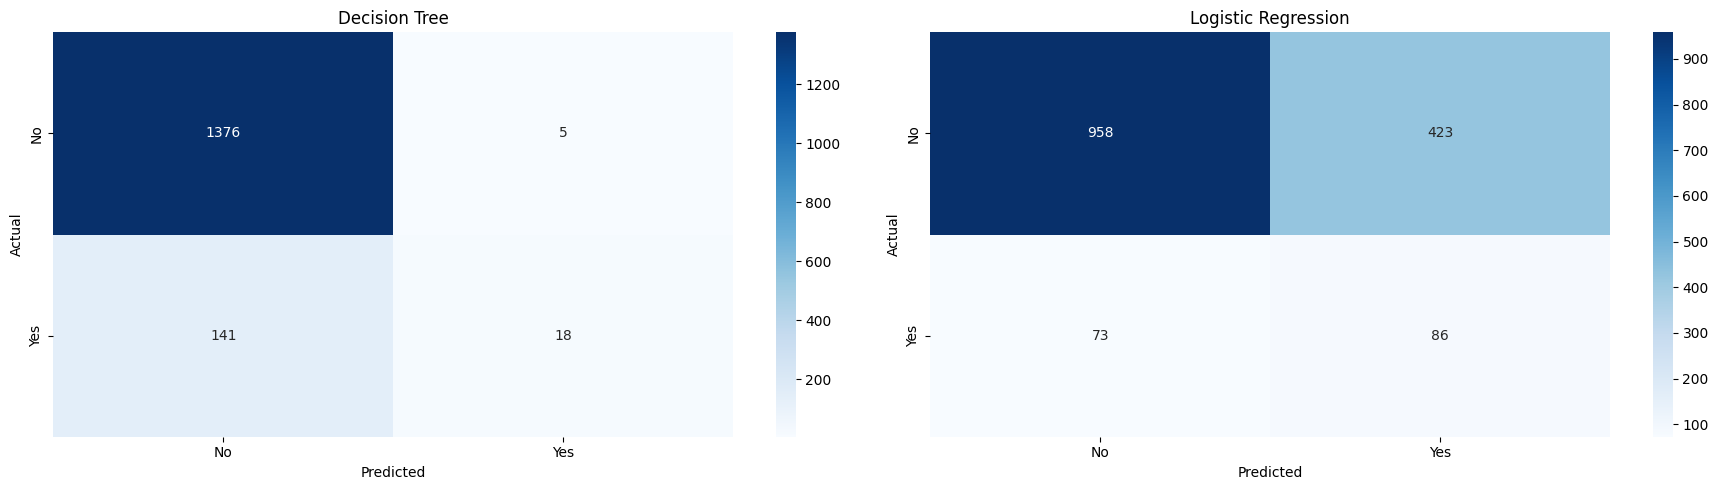

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

for ax, cm_data, title in zip(axes, 
    [cm, cm_lr, ], 
    ['Decision Tree', 'Logistic Regression']):
    sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

The confusion matrix heatmaps compare all three models side by side. The Decision Tree shows a more balanced distribution between classes, while Logistic Regression and Random Forest heavily favor the majority class (No Investment).

### 13.4 Decision Tree Visualization

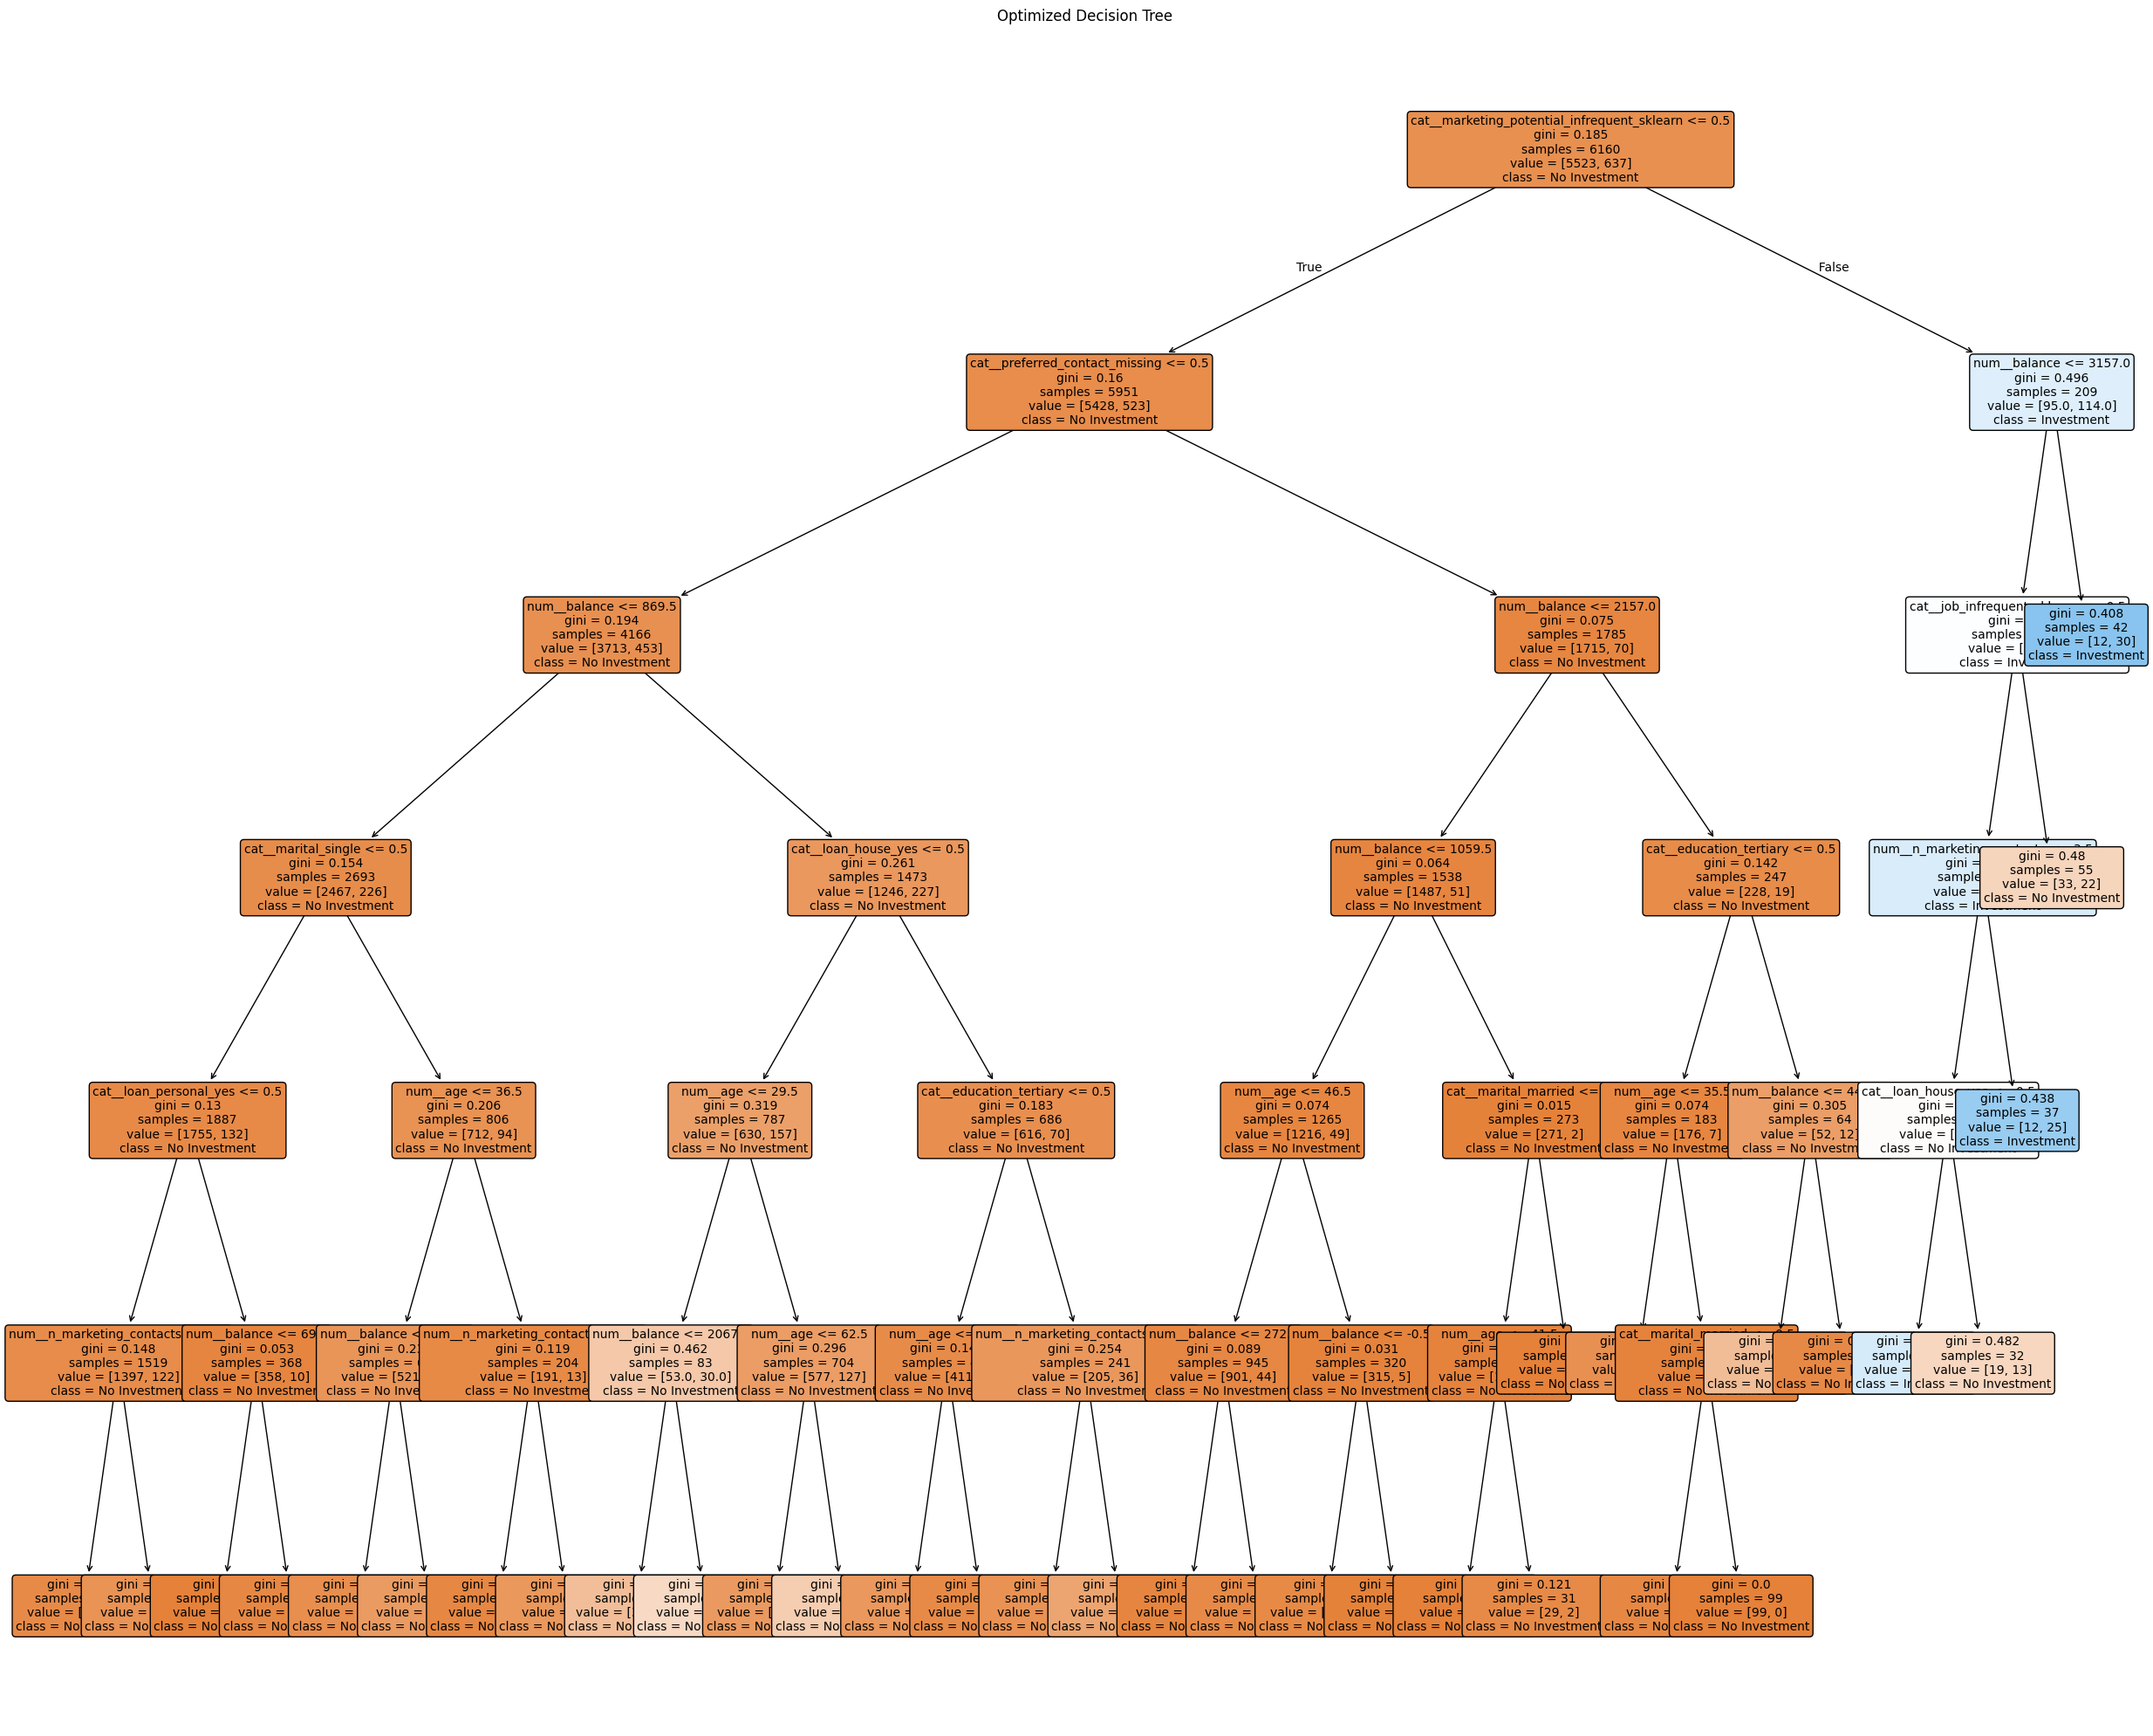

In [ ]:
best_tree = cv.best_estimator_.named_steps['classifier']

feature_names_all_dt = cv.best_estimator_.named_steps['preprocess'].get_feature_names_out()
variance_mask_dt = cv.best_estimator_.named_steps['var_filter'].get_support()
selected_features_dt = feature_names_all_dt[variance_mask_dt]

plt.figure(figsize=(25, 20))
tree.plot_tree(best_tree,
               feature_names=selected_features_dt,
               class_names=['No Investment', 'Investment'],
               filled=True,
               rounded=True,
               fontsize=10)
plt.title('Optimized Decision Tree')
plt.tight_layout()
plt.show()

The tree visualization shows the decision rules the model learned. Each node displays the split condition, the number of samples, and the predicted class. Blue nodes lean towards No Investment, orange nodes towards Investment. The limited depth (max_depth=5) keeps the tree interpretable, which is a key advantage over more complex models like Random Forest.

## 14. Prediction on Period 2

In [ ]:
df_2

,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,period
0,15401,40,services,married,secondary,cellular,3192.19,yes,no,0,unknown,2
1,15402,44,technician,married,secondary,cellular,5266.33,no,no,0,unknown,2
2,15403,33,NaN,married,secondary,cellular,362.91,no,no,6,low,2
3,15404,36,unemployed,divorced,primary,telephone,-20.18,no,no,1,unknown,2
4,15405,58,retired,married,primary,cellular,-89.65,yes,yes,0,unknown,2
...,...,...,...,...,...,...,...,...,...,...,...,...
7695,23096,52,admin.,married,secondary,cellular,855.15,yes,no,0,unknown,2
7696,23097,43,management,married,primary,cellular,98.34,no,yes,0,unknown,2
7697,23098,50,unemployed,married,secondary,telephone,591.10,yes,no,0,unknown,2
7698,23099,46,services,married,secondary,NaN,156.23,yes,no,0,unknown,2


In [ ]:
df_2 = df_2[df_2['balance'] > 505]

In [ ]:
#columns_to_drop = ["id", "period"]
#df_2 = df_2.drop(columns=columns_to_drop)


df_2["Predicted probabilities"] = cv.predict_proba(df_2)[:, 1]

/var/folders/sn/7fc_00nn613gpgj9m28kjnjr0000gn/T/ipykernel_20808/1417943199.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["Predicted probabilities"] = cv.predict_proba(df_2)[:, 1]


In [ ]:
df_2

,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,Predicted probabilities
0,40,services,married,secondary,cellular,3192.19,yes,no,0,unknown,0.067500
1,44,technician,married,secondary,cellular,5266.33,no,no,0,unknown,0.164363
7,48,blue-collar,married,primary,NaN,569.17,yes,yes,0,unknown,0.007326
11,51,blue-collar,married,primary,cellular,3197.92,yes,no,1,low,0.067500
12,35,blue-collar,married,secondary,cellular,3259.84,yes,no,0,unknown,0.067500
...,...,...,...,...,...,...,...,...,...,...,...
7690,57,retired,married,tertiary,cellular,1379.88,no,no,1,unknown,0.164363
7693,35,entrepreneur,married,secondary,cellular,1377.75,yes,no,1,unknown,0.067500
7694,34,management,married,tertiary,cellular,7487.81,no,no,0,unknown,0.164363
7695,52,admin.,married,secondary,cellular,855.15,yes,no,0,unknown,0.069536


## 15. Submission File

In [ ]:
# Create submission file
submission = df_1[['id']].copy()
submission['target'] = df_1['target'].values

print("Target distribution:")
print(submission['target'].value_counts())
print(f"\nFirst rows:")
print(submission.head(10))

# Export
submission.to_csv("submission_period_1.csv", index=False)
print("\nFile saved: submission_period_1.csv")

Target distribution:
target
0    6500
1    1200
Name: count, dtype: int64

First rows:
         id  target
2954  10655       1
3528  11229       1
4238  11939       1
3496  11197       1
1778   9479       1
6986  14687       1
6913  14614       1
5586  13287       1
6843  14544       1
7062  14763       1

File saved: submission_period_1.csv


The submission file contains the client id and the target variable (1 = contact, 0 = do not contact). A total of 1,200 clients are selected for outreach based on their predicted probability of investing.

## 17. Enlarged Dataset

Clients predicted to invest in Period 1 (target = 1 in the submission file) are merged with their characteristics from `period_1_prediction.csv` and appended to the Period 0 data. This creates an enlarged training dataset for future model iterations.


In [ ]:
# Preview: Period 1 rows with actual investment outcomes
Enlarged_dataset[Enlarged_dataset['period'] == 1][['id', 'age', 'job', 'balance', 'investment', 'invested']].head(20)


Clients predicted to invest in Period 1: 1200
Matched in period_1_prediction.csv:       1200

Period 0 rows:          7700
Period 1 rows added:    1200
Enlarged dataset total: 8900

Columns: ['id', 'age', 'job', 'marital', 'education', 'preferred_contact', 'balance', 'loan_house', 'loan_personal', 'n_marketing_contacts', 'marketing_potential', 'call_length', 'investment', 'period']

Missing values per column:
job                    58
education             390
preferred_contact    2283
call_length          1200
investment           1200
dtype: int64


In [ ]:
Enlarged_dataset
